In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from os import listdir
# import skimage.exposure

In [3]:
train=pd.read_csv("Data/Training_set_food.csv")
test=pd.read_csv("Data/Testing_set_food.csv")
sub=pd.read_csv("Data/sample_submission.csv")

In [4]:
train.head()

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers


In [5]:
train["label"].value_counts()

burgers       1800
Pizza         1800
Softdrinks    1800
Name: label, dtype: int64

In [6]:
train.shape , test.shape

((5400, 2), (1800, 1))

In [7]:
lb=LabelEncoder()
train["food_no"]=lb.fit_transform(train["label"])

In [8]:
train.head()

,filename,label,food_no
0,Image_1.jpg,burgers,2
1,Image_2.jpg,burgers,2
2,Image_3.jpg,burgers,2
3,Image_4.jpg,burgers,2
4,Image_5.jpg,burgers,2


In [9]:
image=cv2.imread("Data/train/Image_99.jpg")
image.shape

(100, 100, 3)

In [10]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [11]:
(X_train["label"].value_counts()/len(X_train))*100

burgers       33.333333
Softdrinks    33.333333
Pizza         33.333333
Name: label, dtype: float64

In [12]:
train_datagen=ImageDataGenerator(rescale=1./255,)

In [13]:
train_generator=train_datagen.flow_from_dataframe(
                                                        dataframe=X_train,
                                                        directory="Data/train",
                                                        x_col="filename",
                                                        y_col="label",
                                                        batch_size=16,
                                                        seed=42,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        target_size=(299,299))

Found 4860 validated image filenames belonging to 3 classes.


In [14]:
valid_datagen=ImageDataGenerator(rescale=1./255.,)
valid_generator=valid_datagen.flow_from_dataframe(
                                                    dataframe=X_valid,
                                                    directory="Data/train",
                                                    x_col="filename",
                                                    y_col="label",
                                                    batch_size=16,
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    target_size=(299,299))

Found 540 validated image filenames belonging to 3 classes.


In [15]:
## showing some image from training
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

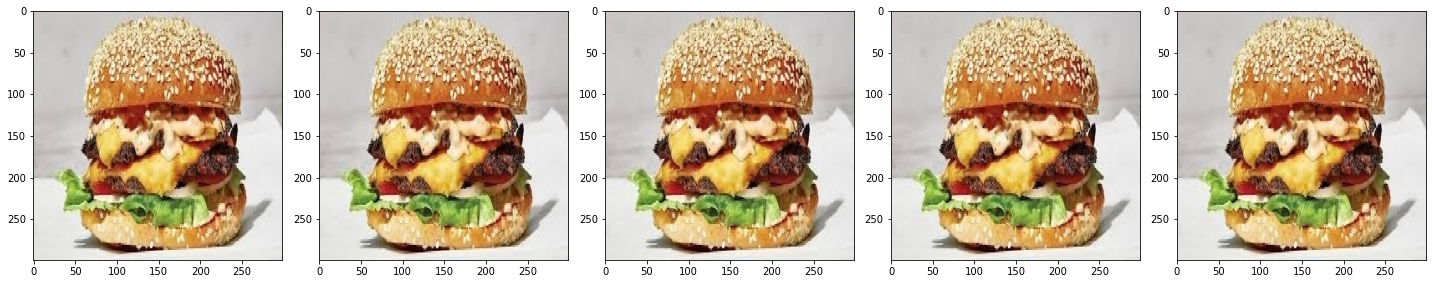

In [16]:
images = [train_generator[0][0][0] for i in range(5)]
plotImages(images)

## Inceptionresnet

In [17]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,ResNet152,EfficientNetB7, MobileNetV2,Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
data_augmentation = keras.Sequential(
[
tf.keras.layers.experimental.preprocessing.CenterCrop(224,224),
]
)

In [19]:
inputs = keras.Input(shape=(299,299, 3))
tensor_x = data_augmentation(inputs)
resnet=InceptionResNetV2(weights="imagenet",input_tensor=tensor_x)

225214464/225209952 [==============================] - 230s 1us/step


In [20]:
x=resnet.layers[-2].output
fc1=Dense(3,kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005),activation='softmax')(x)
my_model=Model(inputs=resnet.input,outputs=fc1)

In [21]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         sequential[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
______________________________________________________________________________________________

activation_168 (Activation)     (None, 5, 5, 192)    0           batch_normalization_168[0][0]    
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 5, 5, 224)    129024      activation_168[0][0]             
__________________________________________________________________________________________________
batch_normalization_169 (BatchN (None, 5, 5, 224)    672         conv2d_169[0][0]                 
__________________________________________________________________________________________________
activation_169 (Activation)     (None, 5, 5, 224)    0           batch_normalization_169[0][0]    
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 5, 5, 192)    399360      block8_1_ac[0][0]                
__________________________________________________________________________________________________
conv2d_170

In [22]:
# Part 3 - Training the CNN

# Compiling the CNN
my_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [3]:
my_model.fit( train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=1,
             validation_data=valid_generator,
             validation_steps=STEP_SIZE_VALID)